In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
import h5py # reccommended by the interpreter (weird) for loading older `.mat` files
import time

In [21]:
PADDING_MODE = 'zeros'
EXAMPLE_INDEX = 20
EXAMPLE_BATCH_SIZE = 2

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [23]:
# stylize matplotlib for whatever is neccessary

mpl.rc('axes', facecolor='#282828', edgecolor='white', linewidth='2.0')
mpl.rc('figure', facecolor='#282828')
mpl.rc('xtick', color='white')
mpl.rc('xtick.major', width='1', size='8')
mpl.rc('ytick', color='white')
mpl.rc('ytick.major', width='1', size='8')
mpl.rc('text', color='white')

# Importing the Dataset

In [24]:
class NYUDepthDataset (Dataset):
	def __init__(self, file_path, transform=None, target_transform=None):
		self.file_path = file_path
		self.data = h5py.File(file_path, 'r')
		self.transform = transform
		self.target_transform = target_transform

	def __len__(self):
		return len(self.data['images'])
	
	def __getitem__(self, idx):
		rgb_image = np.swapaxes(self.data['images'][idx], 0, 2)
		depth_image = np.swapaxes(self.data['depths'][idx], 0, 1)

		# print(rgb_image.shape)

		if self.transform:
			# print(torch.from_numpy(rgb_image).size())
			rgb_image = self.transform(rgb_image)
		if self.target_transform:
			depth_image = self.target_transform(depth_image)
			depth_image -= depth_image.min()
			depth_image /= depth_image.max()

		return rgb_image, depth_image

In [25]:
def show_grid(size, images, text=None, filename=None):
	figure, axs = plt.subplots(nrows=size[0], ncols=size[1])
	# figure.tight_layout()
	figure.set_size_inches(size[1]*3, size[0]*3)

	for i in range(len(axs)):
		for j in range(len(axs[i])):
			axs[i][j].imshow(images[i*len(axs[i]) + j])
			axs[i][j].set_xticks([])
			axs[i][j].set_yticks([])
			if text:
				axs[i][j].set_title(text[i*len(axs[i]) + j])
	
	if filename:
		plt.savefig(filename, dpi=500)


Image Data: 1449 images of size torch.Size([3, 480, 640])
tensor([[[0.5247, 0.5247, 0.5248,  ..., 0.2445, 0.2445, 0.2445],
         [0.5247, 0.5247, 0.5248,  ..., 0.2445, 0.2445, 0.2445],
         [0.5246, 0.5246, 0.5247,  ..., 0.2445, 0.2444, 0.2444],
         ...,
         [0.2199, 0.2198, 0.2198,  ..., 0.1556, 0.1554, 0.1554],
         [0.2198, 0.2198, 0.2197,  ..., 0.1558, 0.1556, 0.1555],
         [0.2198, 0.2197, 0.2197,  ..., 0.1558, 0.1557, 0.1556]]])


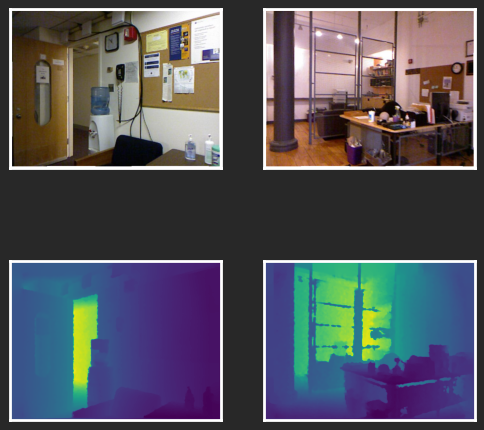

In [26]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=(0, 0, 0), std=(255, 255, 255))
])

depth_transform = transforms.Compose([
	transforms.ToTensor()
])

rng = torch.Generator().manual_seed(420)

NYU_data = NYUDepthDataset('data/NYU/nyu_depth_v2_labeled.mat', transform=transform, target_transform=depth_transform)
NYU_training, NYU_testing = random_split(NYU_data, (0.85, 0.15), generator=rng)

image_width, image_height = NYU_data[0][1].shape[1:]

def npImage(tensor):
	return np.swapaxes(np.swapaxes(tensor.detach().numpy(), 0, 2), 0, 1)

plot_images = [npImage(torch.mul(NYU_data[i+EXAMPLE_INDEX][0], 255)) for i in range(EXAMPLE_BATCH_SIZE)]
plot_images.extend([npImage(NYU_data[i+EXAMPLE_INDEX][1]) for i in range(EXAMPLE_BATCH_SIZE)])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')
print(NYU_data[0][1])
show_grid((2, EXAMPLE_BATCH_SIZE), plot_images)

# Initialising the Model

In [27]:
class fDense (nn.Module):
	class compoundLayer (nn.Module):
		def __init__(self, inChannels, k):
			super().__init__()
			self.norm = nn.BatchNorm2d(inChannels)
			self.conv = nn.Conv2d(inChannels, k, 3, stride=1, padding=1, padding_mode=PADDING_MODE, bias=True)
		
		def forward(self, x):
			intermediateOutput = F.relu(self.norm(x))
			x = torch.cat((x, self.conv(intermediateOutput)), dim=1)
			return x


	def __init__(self, inChannels, outChannels, l=4, k=32):
		super().__init__()
		modules = nn.ModuleList()
		for i in range(l):
			# the input channel count for layer i+1 is k_{i+1} = k_0 + ik
			modules.append(fDense.compoundLayer(inChannels + k*i, k))
		
		# 1x1 convolution to remap to correct channel number
		modules.append(nn.Conv2d(inChannels + k*l, outChannels, 1).to(device))

		self.layers = nn.Sequential(*modules)

	def forward(self, x):
		return self.layers(x)

In [28]:
class Bottleneck (nn.Module):
    def __init__(self, in_channels, out_channels, t, s, n):
        super().__init__()
        
        layers = []

        conv1 = nn.Conv2d(in_channels, t*in_channels, 1)
        dwise_conv = nn.Conv2d(t*in_channels, t*in_channels, 3, padding=1, groups=t*in_channels, stride=s, padding_mode=PADDING_MODE)
        conv2 = nn.Conv2d(t*in_channels, out_channels, 1)

        layers.append(nn.Sequential(conv1, nn.ReLU6(), dwise_conv, nn.ReLU6(), conv2))

        for i in range(n-1):
            conv1 = nn.Conv2d(out_channels, t*out_channels, 1)
            dwise_conv = nn.Conv2d(t*out_channels, t*out_channels, 3, padding=1, groups=t*out_channels, padding_mode=PADDING_MODE)
            conv2 = nn.Conv2d(t*out_channels, out_channels, 1)

            layers.append(nn.Sequential(conv1, nn.ReLU6(), dwise_conv, nn.ReLU6(), conv2))

        self.operations = nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.operations(x)

        return x

In [29]:
class SE (nn.Module):
	def __init__(self, inChannels, outChannels, w, h):
		super().__init__()
		self.scalarUpsample = nn.Upsample((w, h))
		self.globalPool = nn.AvgPool2d((w, h))
		self.fc1 = nn.Linear(1, 1)
		self.fc2 = nn.Linear(1, 1)

		self.conv = nn.Conv2d(inChannels, outChannels, 1)

	def forward(self, x):
		scalars = self.globalPool(x)
		scalars = F.relu(self.fc1(scalars))
		scalars = F.sigmoid(self.fc2(scalars))
		scalars = self.scalarUpsample(scalars)
		x = self.conv(torch.mul(x, scalars))
		return x

In [30]:
class DisparityConvolution (nn.Module):
	def __init__(self, inChannels):
		super().__init__()
		self.conv = nn.Conv2d(inChannels, 1, 3, stride=1, padding=1, padding_mode=PADDING_MODE, bias=True)
	
	def forward(self, x):
		# paper uses sigmoid, switching to relu for data
		x = F.sigmoid(self.conv(x))
		# x = F.relu(self.conv(x))
		return x

In [31]:
class FastMDE (nn.Module):
	def __init__(self, w, h):
		super().__init__()
		self.pool = nn.MaxPool2d(2)
		self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
		self.upsampleToOrig = nn.Upsample(size=(w, h), mode='nearest')

		# several layers of increasing channels and decreasing resolutions

		# mobilenet v2
		pretrainedMobileNet = torchvision.models.mobilenet_v2(weights='IMAGENET1K_V2')

		self.feature1 = pretrainedMobileNet.features[0:2]
		self.feature2 = pretrainedMobileNet.features[2:4]
		self.feature3 = pretrainedMobileNet.features[4:7]
		self.feature4 = pretrainedMobileNet.features[7:11]
		self.feature5 = pretrainedMobileNet.features[11:17]

		# fastMDE
		self.ese4 = SE(224, 160, w//16, h//16)
		self.ese3 = SE(96, 64, w//8, h//8)
		self.ese2 = SE(56, 32, w//4, h//4)
		self.ese1 = SE(40, 24, w//2, h//2)

		self.fDense5 = nn.Sequential(fDense(160, 160), self.upsample)
		self.fDense4 = nn.Sequential(fDense(160, 160), self.upsample)
		self.fDense3 = nn.Sequential(fDense(64, 64), self.upsample)
		self.fDense2 = nn.Sequential(fDense(32, 32), self.upsample)
		self.fDense1 = nn.Sequential(fDense(72, 72), self.upsample)

		self.dse4 = nn.Sequential(nn.Conv2d(384, 384, 3, stride=1, padding=1, padding_mode=PADDING_MODE), SE(384, 160, w//16, h//16))
		self.dse3 = nn.Sequential(nn.Conv2d(256, 256, 3, stride=1, padding=1, padding_mode=PADDING_MODE), SE(256, 64, w//8, h//8))
		self.dse2 = nn.Sequential(nn.Conv2d(120, 120, 3, stride=1, padding=1, padding_mode=PADDING_MODE), SE(120, 32, w//4, h//4))
		self.dse1 = nn.Sequential(nn.Conv2d(72, 72, 3, stride=1, padding=1, padding_mode=PADDING_MODE), SE(72, 16, w, h))

		self.disparity1 = DisparityConvolution(16)
		self.disparity2 = DisparityConvolution(32)
		self.disparity3 = DisparityConvolution(64)
		self.disparity4 = DisparityConvolution(160)

		print(self)

	def forward(self, x):
		layer1 = self.feature1(x)
		layer2 = self.feature2(layer1)
		layer3 = self.feature3(layer2)
		layer4 = self.feature4(layer3)
		layer5 = self.feature5(layer4)

		layer6 = self.ese4(torch.cat((self.upsample(layer5), layer4), dim=1))
		layer7 = self.ese3(torch.cat((self.upsample(layer4), layer3), dim=1))
		layer8 = self.ese2(torch.cat((self.upsample(layer3), layer2), dim=1))
		layer9 = self.ese1(torch.cat((self.upsample(layer2), layer1), dim=1))

		layer10 = self.fDense5(layer5)
		layer11 = self.dse4(torch.cat((layer10, layer6, layer4), dim=1))
		layer12 = self.fDense4(layer11)
		layer13 = self.dse3(torch.cat((layer12, layer7, layer3), dim=1))
		layer14 = self.fDense3(layer13)
		layer15 = self.dse2(torch.cat((layer14, layer8, layer2), dim=1))
		layer16 = self.fDense2(layer15)
		layer17 = self.fDense1(torch.cat((layer16, layer9, layer1), dim=1))
		layer18 = self.dse1(layer17)

		outputScale1 = self.disparity1(layer18)
		outputScale2 = self.upsampleToOrig(self.disparity2(layer15))
		outputScale3 = self.upsampleToOrig(self.disparity3(layer13))
		outputScale4 = self.upsampleToOrig(self.disparity4(layer11))

		return torch.cat((outputScale1, outputScale2, outputScale3, outputScale4), dim=1)

In [32]:
model = FastMDE(image_width, image_height).to(device)

FastMDE(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (upsampleToOrig): Upsample(size=(480, 640), mode='nearest')
  (feature1): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )


In [33]:
def getNumParams(model):
	pp=0
	for p in list(model.parameters()):
		nn=1
		for s in list(p.size()):
			nn = nn*s
		pp += nn
	return pp

print(getNumParams(model))

4531972


torch.Size([2, 4, 480, 640])
[[0.50944054 0.5121304  0.5507646  ... 0.50723326 0.51778334 0.5254077 ]
 [0.5548119  0.49331892 0.5648957  ... 0.5116144  0.55694526 0.53329533]
 [0.47090435 0.37745932 0.49410918 ... 0.5227129  0.58091205 0.5574098 ]
 ...
 [0.45622063 0.33576193 0.47142276 ... 0.47178292 0.49932525 0.49994516]
 [0.4673266  0.36197534 0.46375766 ... 0.4586406  0.47680438 0.47506335]
 [0.46227032 0.44692457 0.5095084  ... 0.5254664  0.5147392  0.5135706 ]]


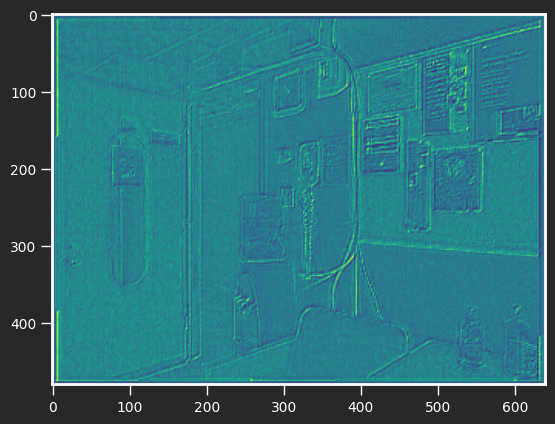

In [34]:
output = model.forward(default_collate([NYU_data[i+EXAMPLE_INDEX][0].to(device) for i in range(2)]))
print(output.size())
plt.imshow(npImage(output[0,:1].cpu()))
print(output[0][0].cpu().detach().numpy())

In [35]:
# but for now
criterion = nn.MSELoss()
# criterion = nn.L1Loss()

# add a loss fn that takes into account each scale of output, maybe? compares with pooled ground truth?

def multiScaleLoss(outputScales, expected):
	expectedStack = torch.cat((expected, expected, expected, expected), dim=1)
	return criterion(outputScales, expectedStack)

# and try Adam optimizer
# optimizer = SGD(model.parameters(), lr=5e-6, momentum=0.9)
optimizer = Adam(model.parameters(), lr=5e-5)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [36]:
NYU_trainingDataLoader = DataLoader(NYU_training, batch_size=8, shuffle=True, num_workers=0)
NYU_testingDataLoader = DataLoader(NYU_testing, batch_size=8, shuffle=True, num_workers=0)

def train_one_epoch(model, epoch_index):
	running_loss = 0.

	batch = 1

	for inputs, groundTruth in iter(NYU_trainingDataLoader):
		if batch % 20 == 0: print(f'batch {batch} / {len(NYU_trainingDataLoader)}')
		inputs = inputs.to(device)
		groundTruth = groundTruth.to(device)

		# Zero your gradients for every batch!
		optimizer.zero_grad()

		# Make predictions for this batch
		outputScales = model(inputs)
		
		# Compute the loss and its gradients
		loss = multiScaleLoss(outputScales, groundTruth)
		loss.backward()

		# Adjust learning weights
		optimizer.step()

		# Gather data and report
		running_loss += loss.item()
		batch += 1
	
	scheduler.step()

	return running_loss / len(NYU_trainingDataLoader)

In [37]:
resume = False
if resume:
    start = 16
    model.load_state_dict(torch.load(f'states/epoch_{start}.pt'))
else:
    start = 0

In [38]:
EPOCHS = 20

losses, v_losses = [], []

for epoch in range(start, EPOCHS):
	print(f'-=-=-=-=- EPOCH {epoch + 1} -=-=-=-=-')
	print('training')
	# Make sure gradient tracking is on, and do a pass over the data
	model.train(True)
	avg_loss = train_one_epoch(model, epoch)
	losses.append(avg_loss)


	running_vloss = 0.0
	# Set the model to evaluation mode, disabling dropout and using population
	# statistics for batch normalization.
	model.eval()

	print('validating')
	# Disable gradient computation and reduce memory consumption.
	with torch.no_grad():
		for vinputs, vlabels in iter(NYU_testingDataLoader):
			vinputs = vinputs.to(device)
			vlabels = vlabels.to(device)

			voutputs = model(vinputs)
			vloss = multiScaleLoss(voutputs, vlabels)
			running_vloss += vloss

	avg_vloss = running_vloss / (len(NYU_testingDataLoader) + 1)
	v_losses.append(avg_vloss)

	print(f'Training loss (MSE): {avg_loss}')
	print(f'Testing loss (MSE): {avg_vloss}')

	torch.save(model.state_dict(), f'states/epoch_{epoch + 1}.pt')

-=-=-=-=- EPOCH 1 -=-=-=-=-
training


KeyboardInterrupt: 

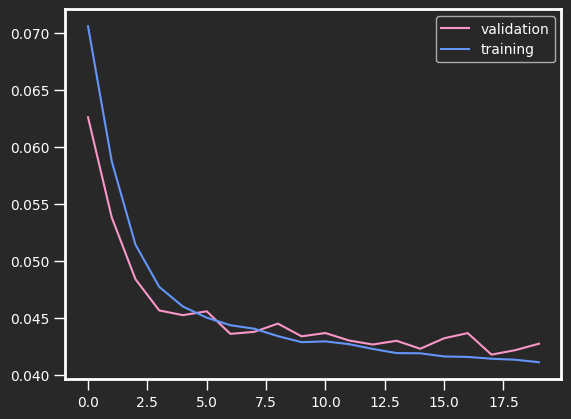

In [ ]:
v_losses = [l.cpu() for l in v_losses]

currentTime = time.localtime()

with open(f'output/losses_{currentTime.tm_year}-{currentTime.tm_mon}-{currentTime.tm_mday}_[{currentTime.tm_hour}-{currentTime.tm_min}-{currentTime.tm_sec}].csv', 'w') as f:
	fileBody = 'loss,val loss\n'
	for i in range(len(losses)):
		fileBody += f'{losses[i]},{v_losses[i]}\n'
	f.write(fileBody)

plt.plot(range(len(v_losses)), v_losses, label='validation', color='#fa96c8')
plt.plot(range(len(losses)), losses, label='training', color='#6496fa')
plt.legend()

[[[0.43197423 0.37510747 0.39095604 ... 0.40426445 0.40339854 0.3965354 ]
  [0.44066596 0.3824629  0.3906862  ... 0.40329504 0.40571252 0.3972577 ]
  [0.44303906 0.4056841  0.40921557 ... 0.40819785 0.41609704 0.4042874 ]
  ...
  [0.17174992 0.15748653 0.15057902 ... 0.22317229 0.23983072 0.23411575]
  [0.15296005 0.14143991 0.14212622 ... 0.2068986  0.22306466 0.21977514]
  [0.16196924 0.14569706 0.14581153 ... 0.2108609  0.22653377 0.2230959 ]]]


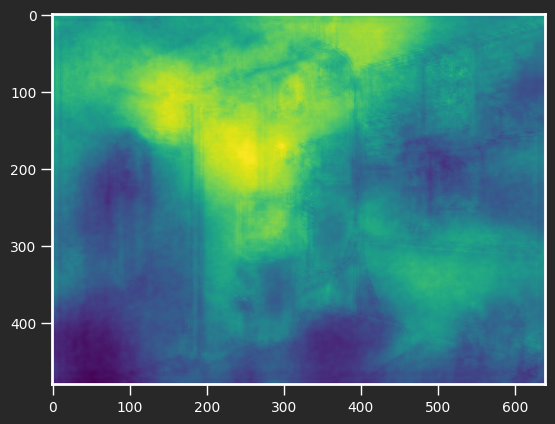

In [ ]:
output = model.forward(default_collate([NYU_data[i+EXAMPLE_INDEX][0].to(device) for i in range(2)]))

plt.imshow(npImage(output[0,:1].cpu()))
print(output[0,:1].cpu().detach().numpy())

Image Data: 1449 images of size torch.Size([3, 480, 640])


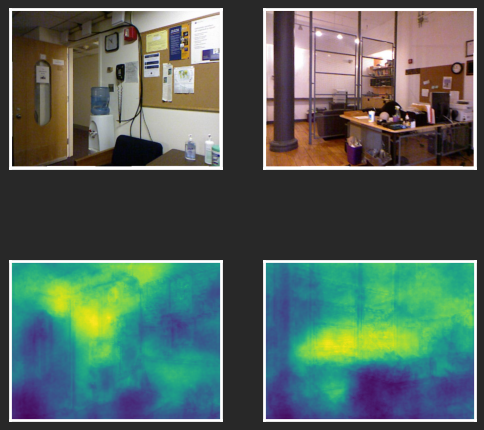

In [ ]:
plot_images = [npImage(torch.mul(NYU_data[i+EXAMPLE_INDEX][0], 255)) for i in range(EXAMPLE_BATCH_SIZE)]
plot_images.extend([npImage(img[:1].cpu()) for img in output])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')

show_grid((2, EXAMPLE_BATCH_SIZE), plot_images)

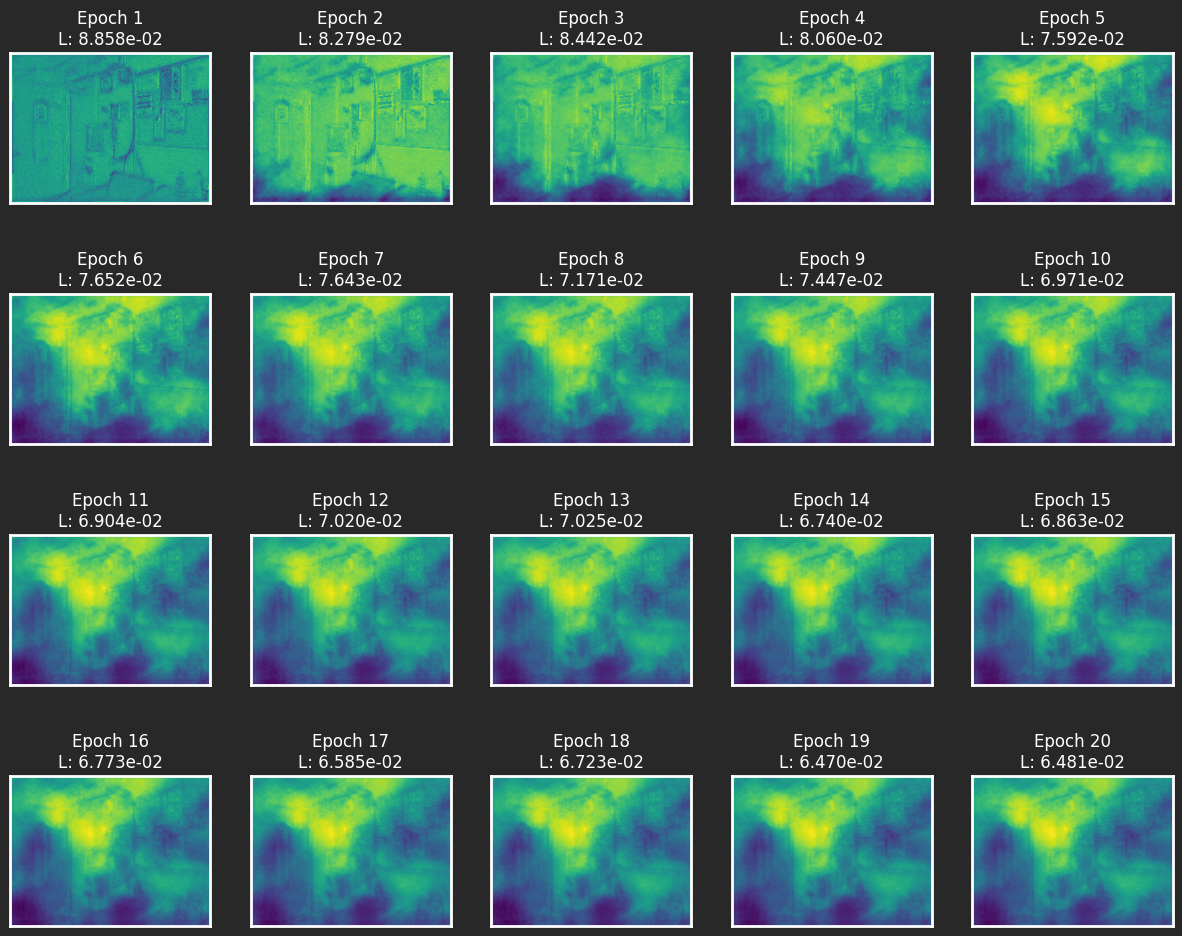

In [ ]:
model.eval()

images = []
texts = []

for epoch in range(EPOCHS):
	model.load_state_dict(torch.load(f'states/epoch_{epoch+1}.pt', map_location=device))

	output = model.forward(default_collate([NYU_data[i+EXAMPLE_INDEX][0].to(device) for i in range(2)]))
	images.append(npImage(output[0,:1].cpu()))
	texts.append(f'Epoch {epoch + 1}\nL: {multiScaleLoss(output[:1], default_collate([NYU_data[EXAMPLE_INDEX][1]]).to(device)):.3e}')

show_grid((EPOCHS//5, 5), images, texts, 'output/epochGrid.png')


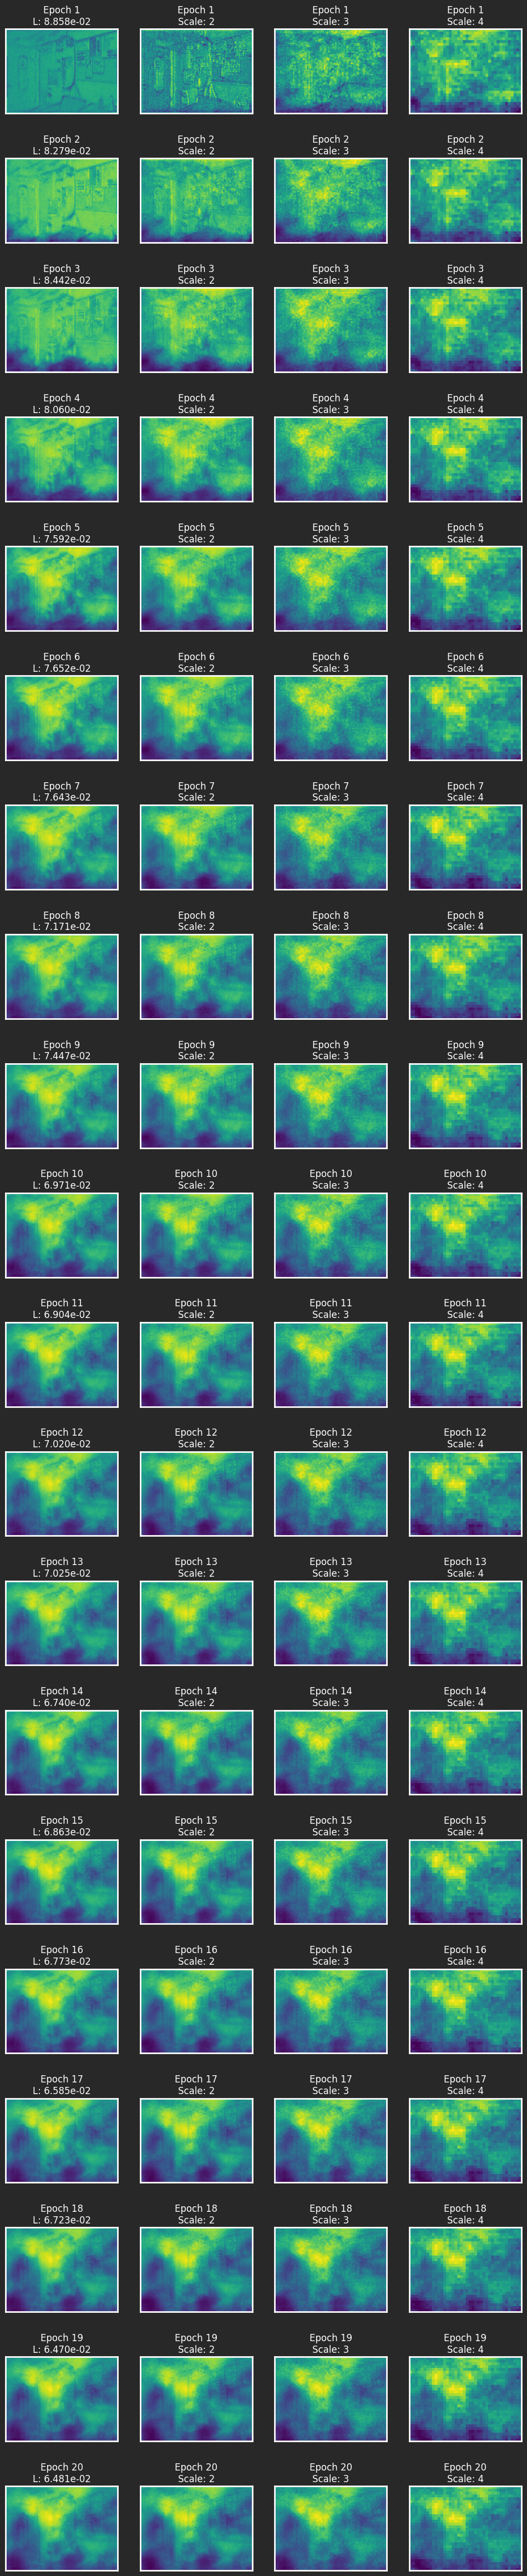

In [ ]:
model.eval()

images = []
texts = []

for epoch in range(EPOCHS):
	model.load_state_dict(torch.load(f'states/epoch_{epoch+1}.pt', map_location=device))

	output = model.forward(default_collate([NYU_data[i+EXAMPLE_INDEX][0].to(device) for i in range(2)]))
	for i in range(4):
		images.append(npImage(output[0,i:i+1].cpu()))
		if i == 0:
			texts.append(f'Epoch {epoch + 1}\nL: {multiScaleLoss(output[i:i+1], default_collate([NYU_data[EXAMPLE_INDEX][1]]).to(device)):.3e}')
		else:
			texts.append(f'Epoch {epoch + 1}\nScale: {i+1}')

show_grid((EPOCHS, 4), images, texts, 'output/epochScaleGrid.png')
